In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from joblib import dump
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Loading datasets
weather = pd.read_csv('dataset/train_timeseries.csv')
soil = pd.read_csv('dataset/soil_data.csv')

print(weather.shape)
print(soil.shape)
weather.head(), soil.head()


(19300680, 21)
(3109, 32)


(   fips        date  PRECTOT      PS   QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
 0  1001  2000-01-01     0.22  100.51   9.65  14.74   13.51   13.51    20.96   
 1  1001  2000-01-02     0.20  100.55  10.42  16.69   14.71   14.71    22.80   
 2  1001  2000-01-03     3.65  100.15  11.76  18.49   16.52   16.52    22.73   
 3  1001  2000-01-04    15.95  100.29   6.42  11.40    6.09    6.10    18.09   
 4  1001  2000-01-05     0.00  101.15   2.95   3.86   -3.29   -3.20    10.82   
 
    T2M_MIN  ...     TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  WS50M  \
 0    11.46  ...  14.65   2.20       2.94       1.49         1.46   4.85   
 1    12.61  ...  16.60   2.52       3.43       1.83         1.60   5.33   
 2    15.32  ...  18.41   4.03       5.33       2.66         2.67   7.53   
 3     2.16  ...  11.31   3.84       5.67       2.08         3.59   6.73   
 4    -2.66  ...   2.65   1.60       2.50       0.52         1.98   2.94   
 
    WS50M_MAX  WS50M_MIN  WS50M_RANGE  score  
 0       6.04

In [4]:
# Check uniqueness and duplicates
print("weather fips unique:", weather['fips'].nunique())
print("soil fips unique:", soil['fips'].nunique())

weather fips unique: 3108
soil fips unique: 3109


In [4]:
# Drop duplicate fips in soil 
soil = soil.drop_duplicates(subset='fips')

In [5]:
# Merge datasets
data = weather.merge(soil, on='fips', how='inner')
print("merged data shape:", data.shape)

data.head()

merged data shape: (19300680, 52)


,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,CULTRF_LAND,CULTIR_LAND,CULT_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
0,1001,2000-01-01,0.22,100.51,9.65,14.74,13.51,13.51,20.96,11.46,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
1,1001,2000-01-02,0.20,100.55,10.42,16.69,14.71,14.71,22.80,12.61,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
2,1001,2000-01-03,3.65,100.15,11.76,18.49,16.52,16.52,22.73,15.32,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
3,1001,2000-01-04,15.95,100.29,6.42,11.40,6.09,6.10,18.09,2.16,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
4,1001,2000-01-05,0.00,101.15,2.95,3.86,-3.29,-3.20,10.82,-2.66,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2


In [6]:
# Remove rows without drought_severity score
data = data[data['score'].notna()]

In [7]:
# Drop irrelevant/sparse columns (>50% NaNs)
data.dropna(thresh=len(data) * 0.5, axis=1, inplace=True)

In [8]:
# Convert date if exists
if 'date' in data.columns:
    data['date'] = pd.to_datetime(data['date'])
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    data['day'] = data['date'].dt.day
    data.drop('date', axis=1, inplace=True)

data.head()

,fips,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,...,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7,year,month,day
3,1001,15.95,100.29,6.42,11.40,6.09,6.10,18.09,2.16,15.92,...,1,1,1,1,1,1,2,2000,1,4
10,1001,1.33,100.40,6.63,11.48,7.84,7.84,18.88,5.72,13.16,...,1,1,1,1,1,1,2,2000,1,11
17,1001,1.11,100.39,9.53,14.28,13.26,13.26,18.04,8.98,9.06,...,1,1,1,1,1,1,2,2000,1,18
24,1001,0.00,100.11,2.05,-0.78,-7.93,-7.72,5.65,-5.46,11.11,...,1,1,1,1,1,1,2,2000,1,25
31,1001,0.00,101.00,3.36,2.06,-1.73,-1.70,11.02,-4.21,15.23,...,1,1,1,1,1,1,2,2000,2,1


In [9]:
numeric_cols = data.select_dtypes(include=np.number).columns
mask = pd.Series(True, index=data.index)
for col in numeric_cols:
    mean = data[col].mean()
    std = data[col].std()
    col_mask = (data[col] >= mean - 3 * std) & (data[col] <= mean + 3 * std)
    mask &= col_mask
data = data[mask]
print("data shape after 3-sigma outlier removal:", data.shape)

data shape after 3-sigma outlier removal: (1989531, 54)


In [10]:
# set the correct target column
target = 'score'

# separate features and target
X = data.drop(columns=[target])
y = data[target]

# standardize the features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X_scaled.head()

,fips,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,...,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7,year,month,day
0,-2.019957,0.275141,1.022695,-0.125702,0.033344,0.090624,0.089035,0.031394,-0.251030,0.789314,...,1.311411,0.890259,-0.216411,1.395864,0.02429,0.0876,-0.21707,-1.619147,-1.621236,-1.327391
1,-2.019957,-0.502187,1.039283,0.232365,0.126438,0.514242,0.513678,0.157380,0.182316,-0.030426,...,1.311411,0.890259,-0.216411,1.395864,0.02429,0.0876,-0.21707,-1.619147,-1.621236,-0.531522
2,-2.019957,-0.461409,1.044813,0.527614,0.327375,0.737514,0.738017,0.232621,0.483277,-0.636665,...,1.311411,0.890259,-0.216411,1.395864,0.02429,0.0876,-0.21707,-1.619147,-1.621236,0.264347
3,-2.019957,-0.520027,0.959106,-1.091018,-0.949219,-1.122419,-1.120795,-0.921371,-0.859619,-0.396805,...,1.311411,0.890259,-0.216411,1.395864,0.02429,0.0876,-0.21707,-1.619147,-1.621236,1.060216
4,-2.019957,-0.509833,1.180284,-0.848118,-0.667170,-0.665908,-0.670114,-0.526792,-0.682471,0.299051,...,1.311411,0.890259,-0.216411,1.395864,0.02429,0.0876,-0.21707,-1.619147,-1.328703,-1.668477


In [11]:
# Round scores to nearest integer and convert to int
y = y.round().astype(int)

# Check the distribution
print(y.value_counts())

score
0    1238425
1     337500
2     207647
3     134442
4      71517
Name: count, dtype: int64


In [12]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_scaled, y)

print("Resampled X shape:", X_res.shape)
print("Resampled y distribution:\n", y_res.value_counts())

Resampled X shape: (6192125, 53)
Resampled y distribution:
 score
1    1238425
2    1238425
3    1238425
4    1238425
0    1238425
Name: count, dtype: int64


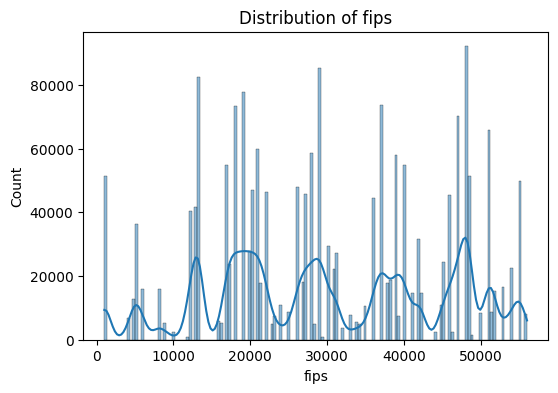

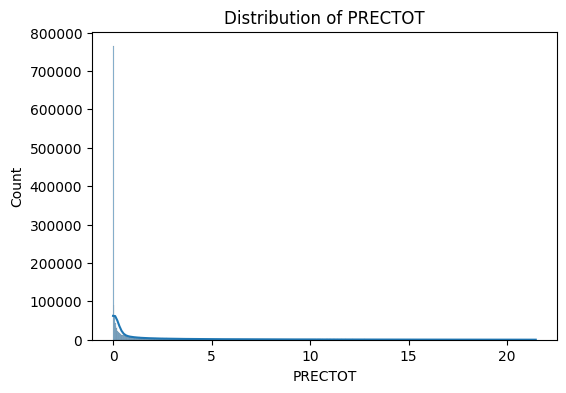

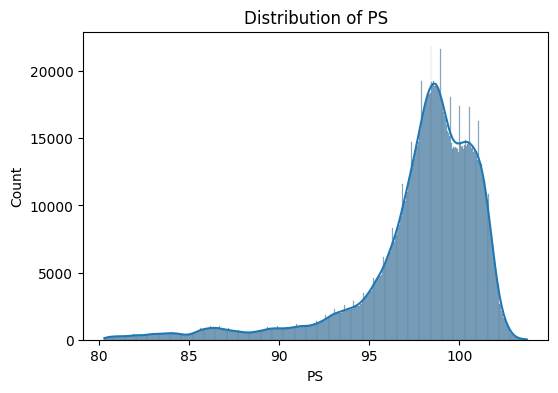

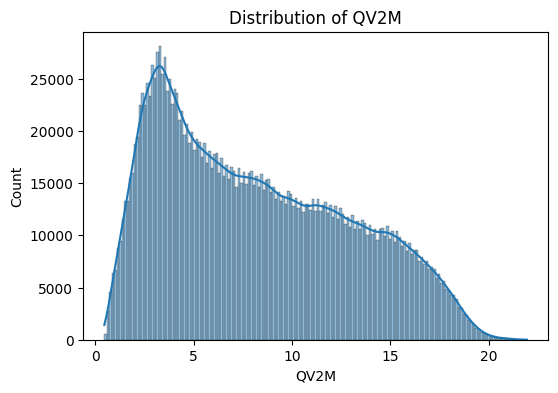

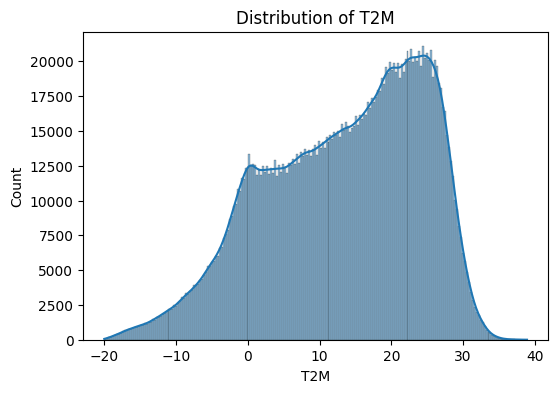

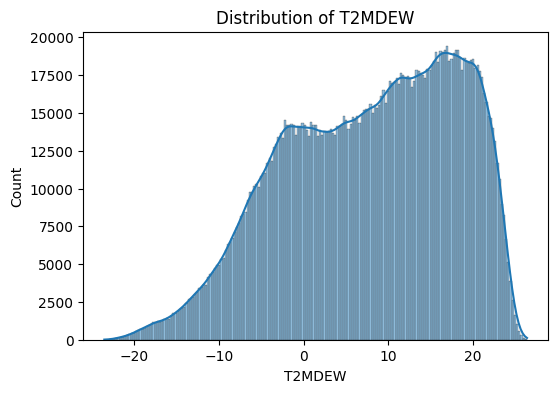

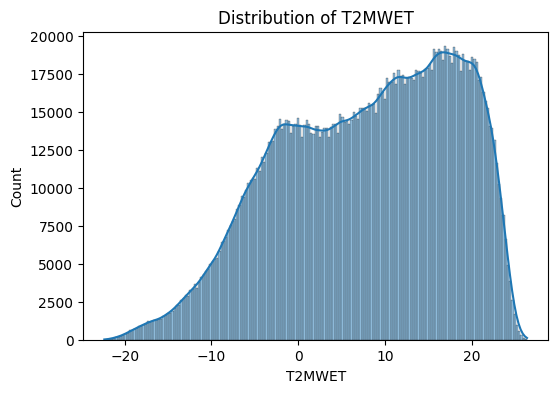

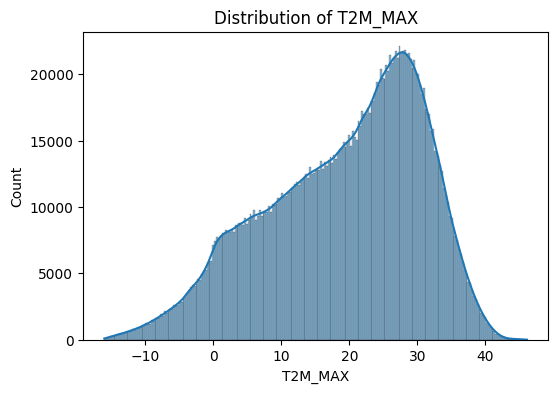

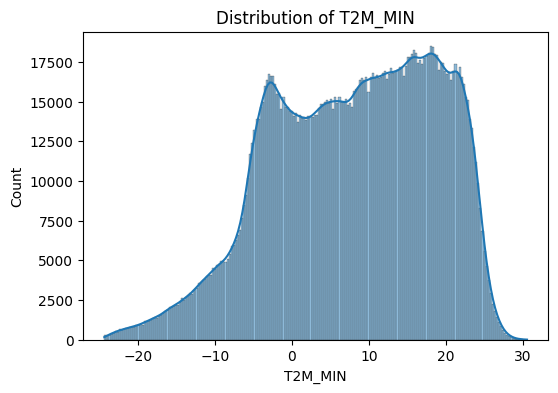

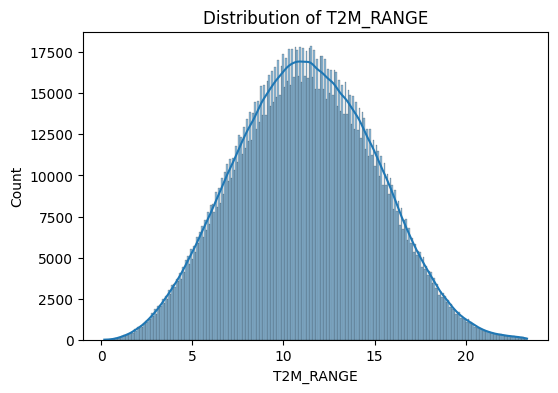

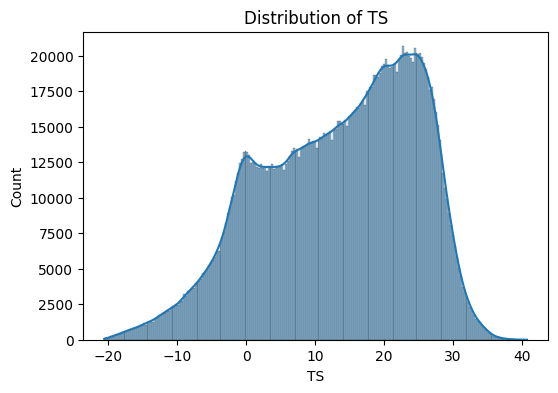

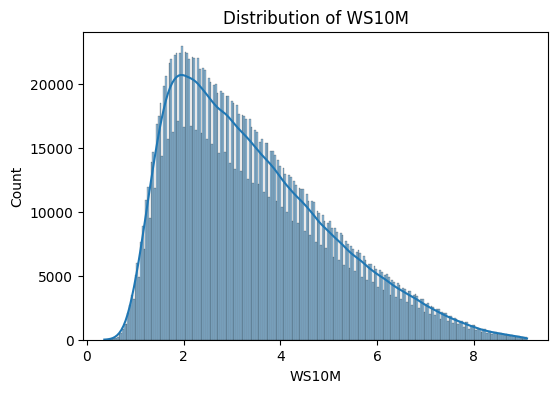

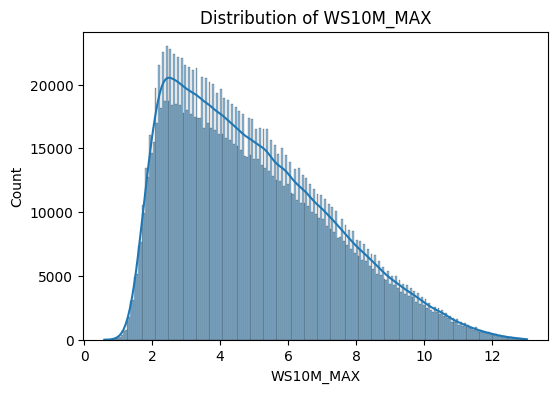

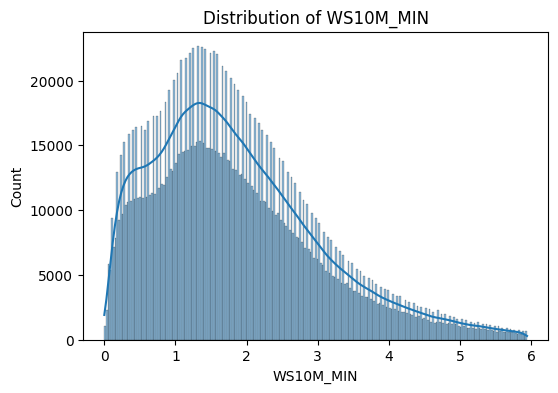

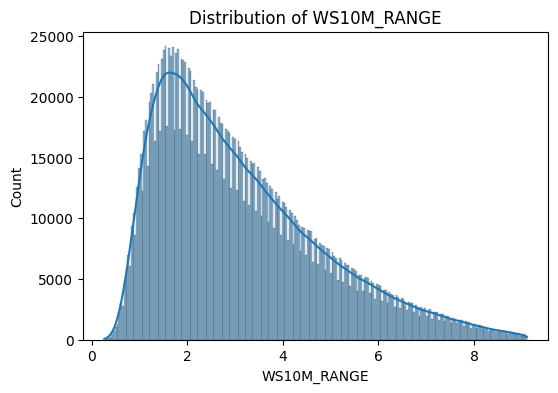

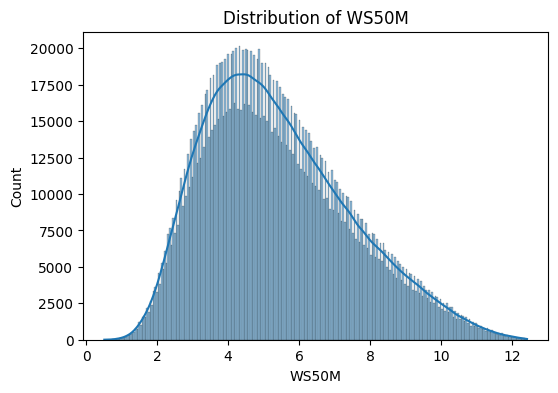

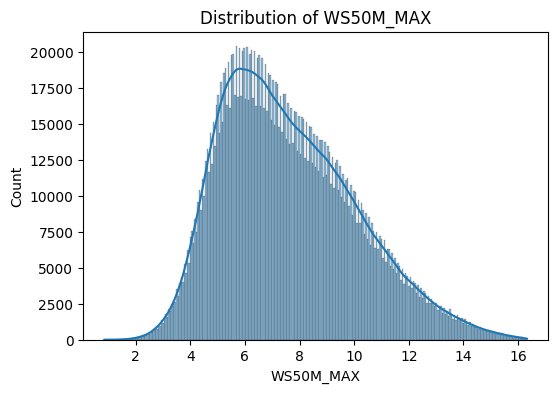

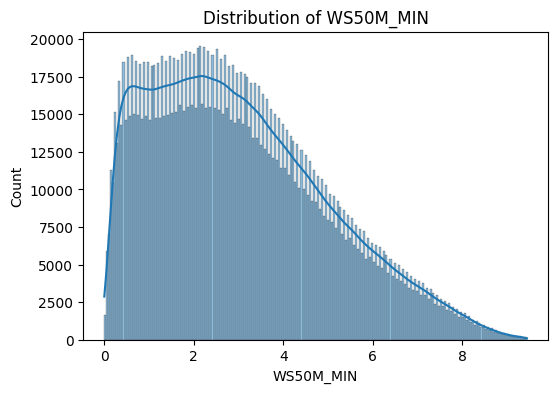

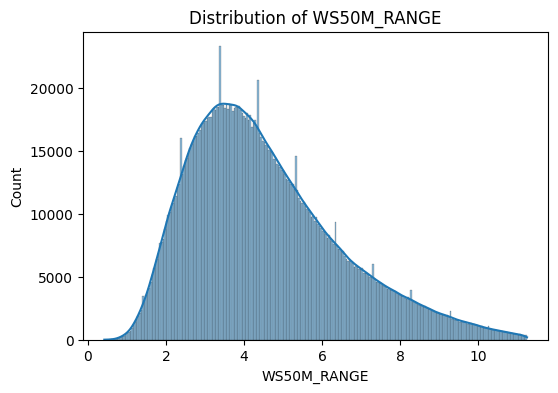

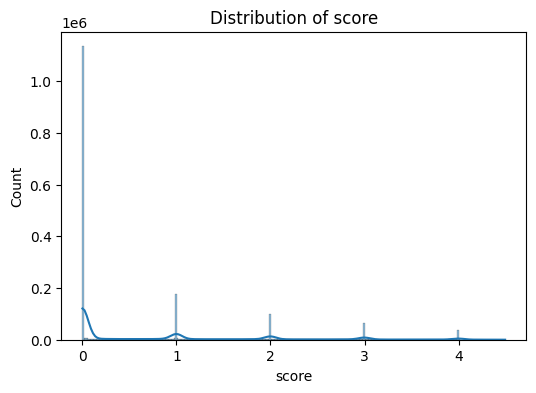

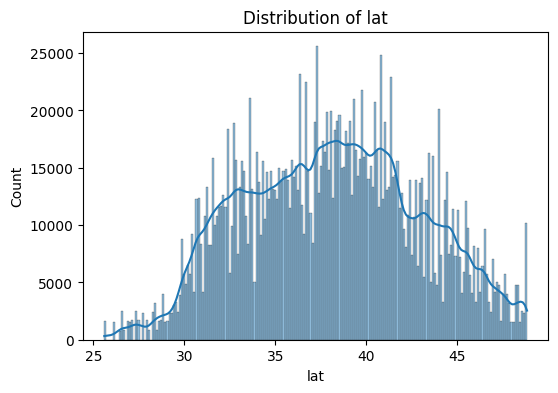

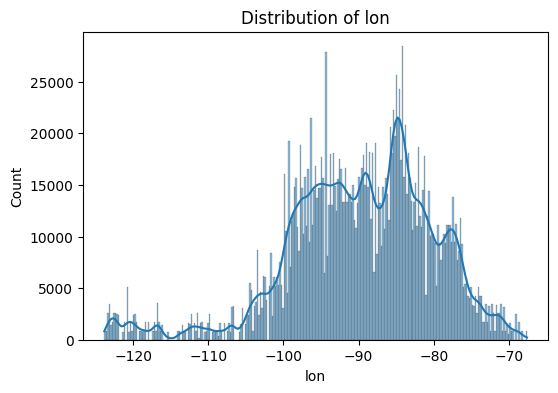

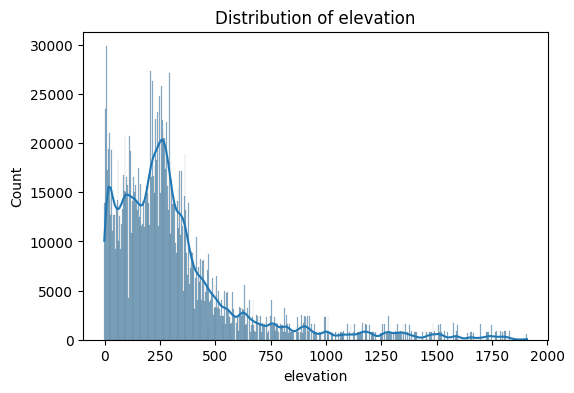

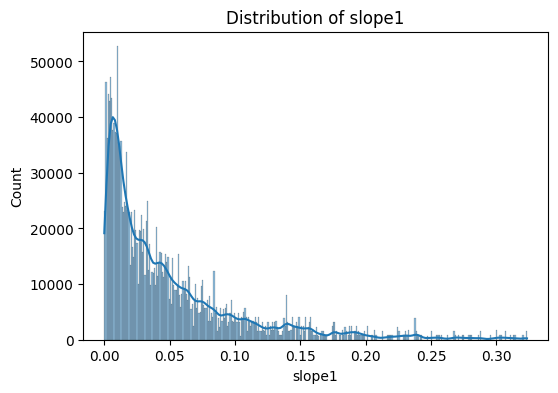

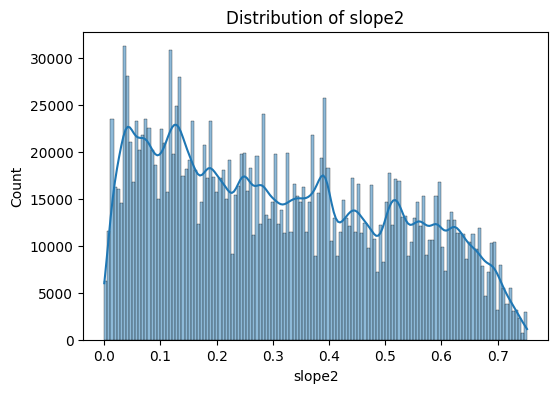

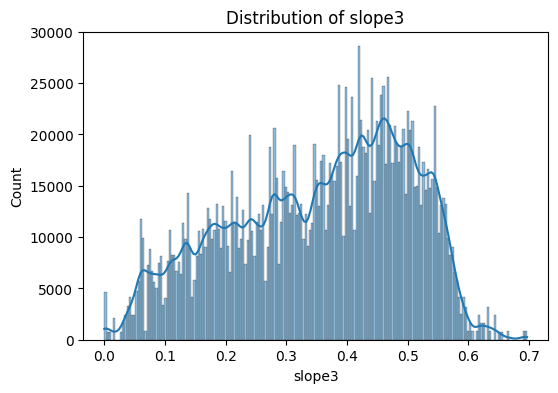

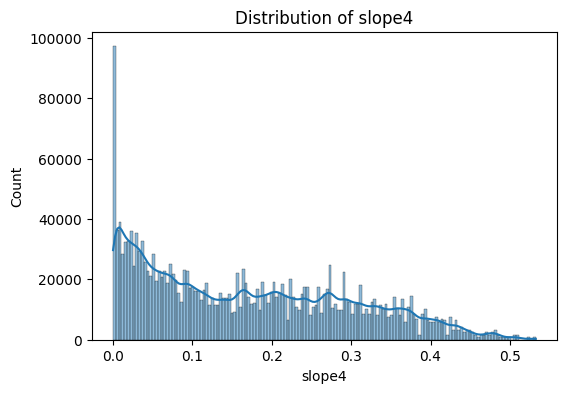

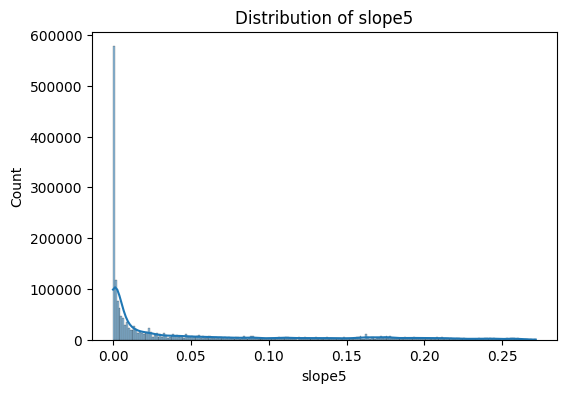

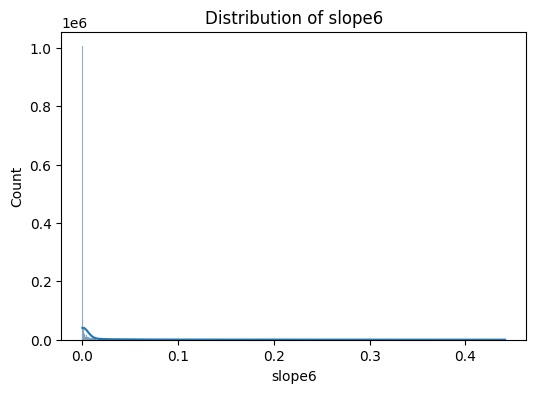

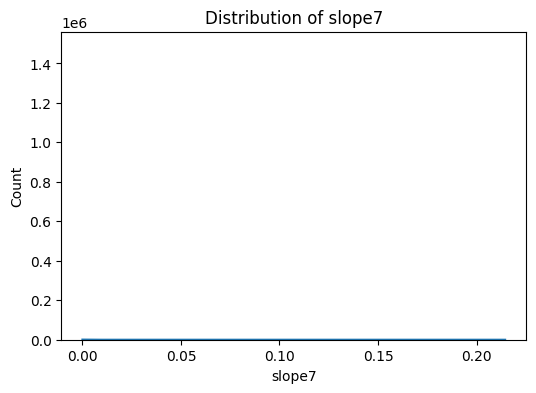

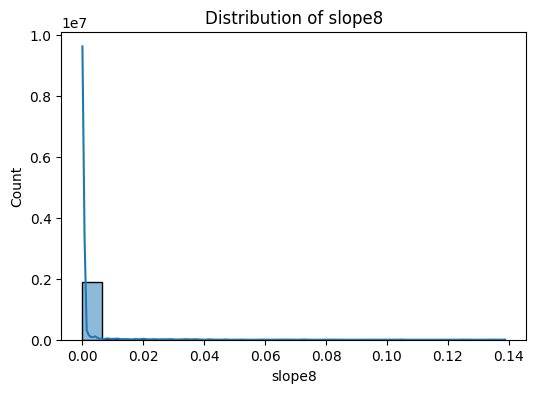

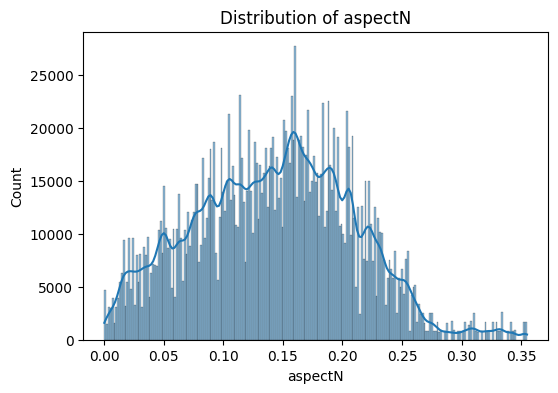

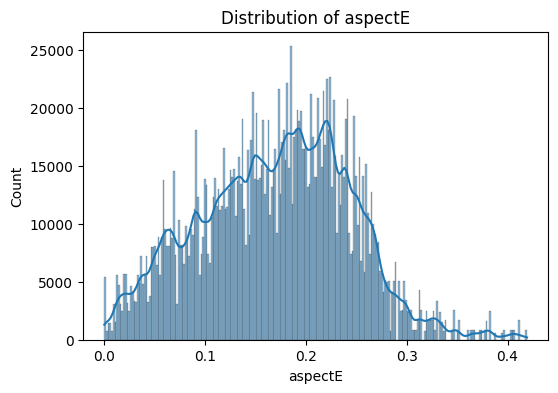

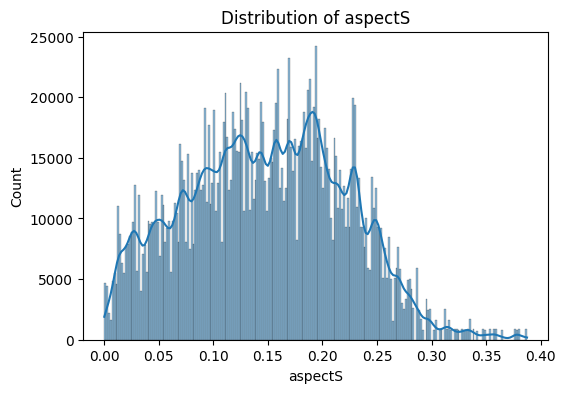

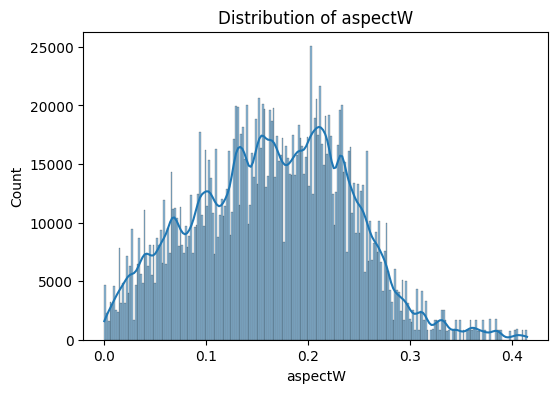

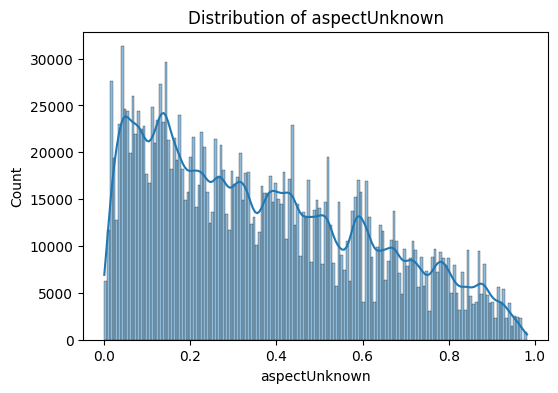

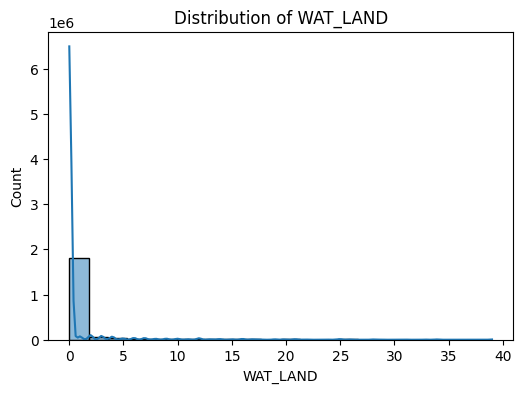

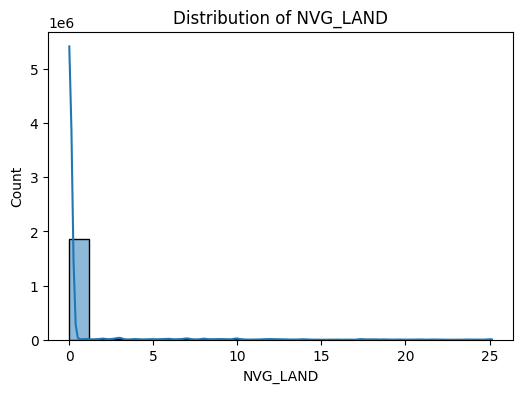

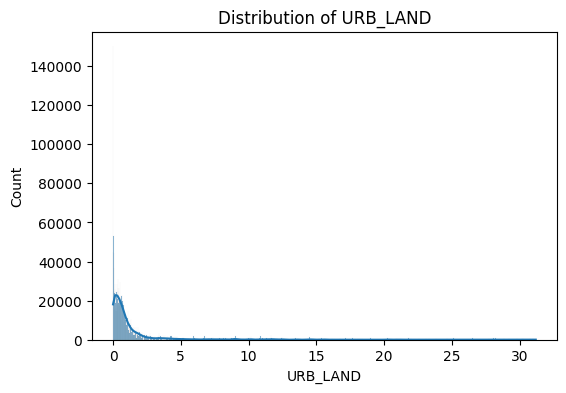

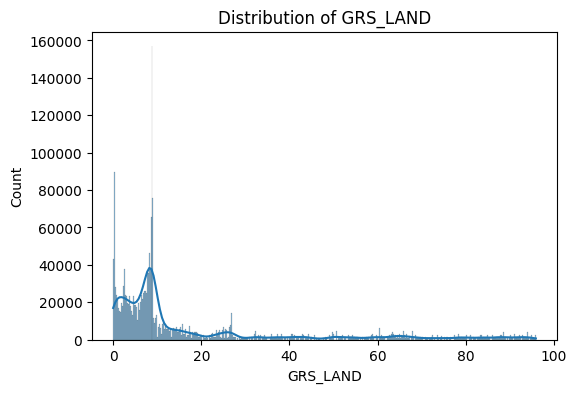

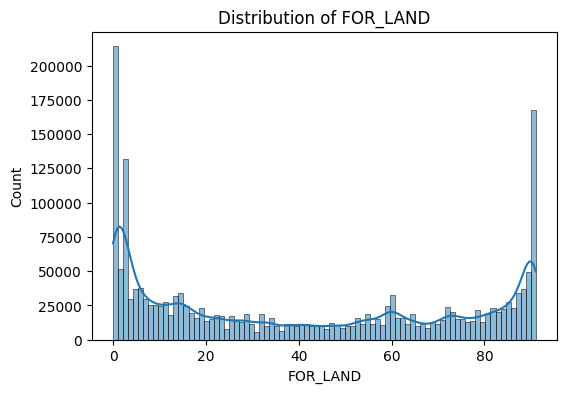

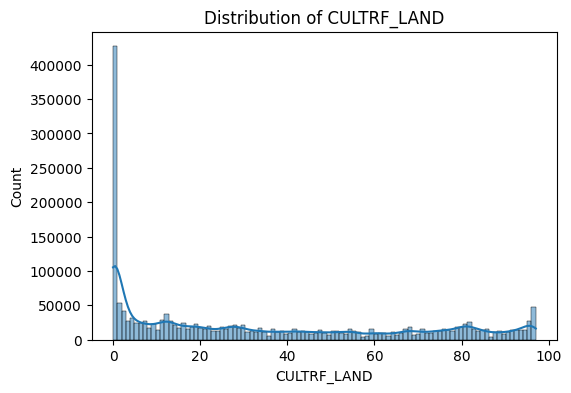

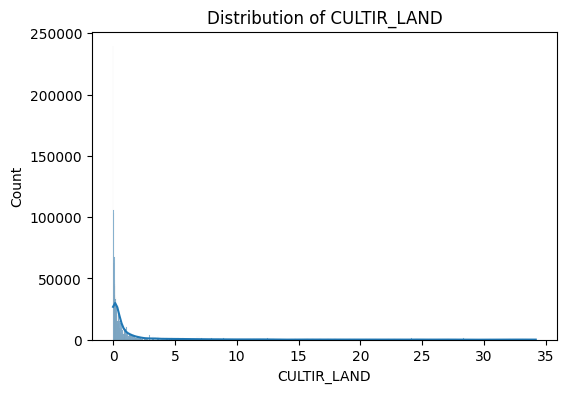

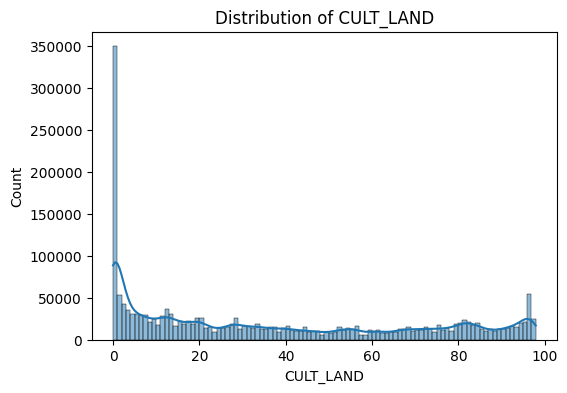

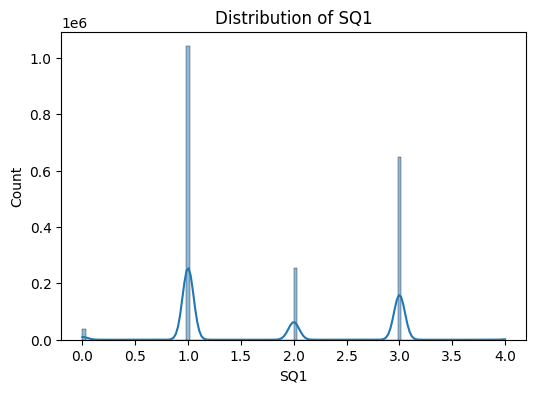

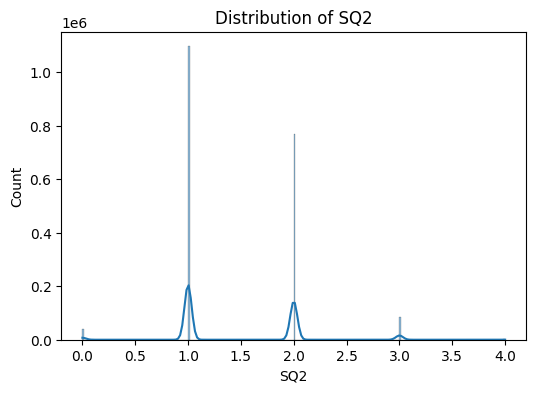

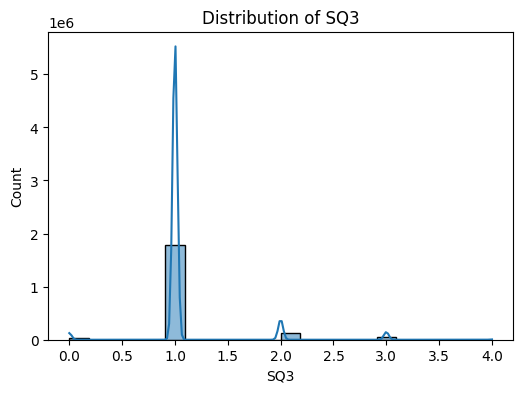

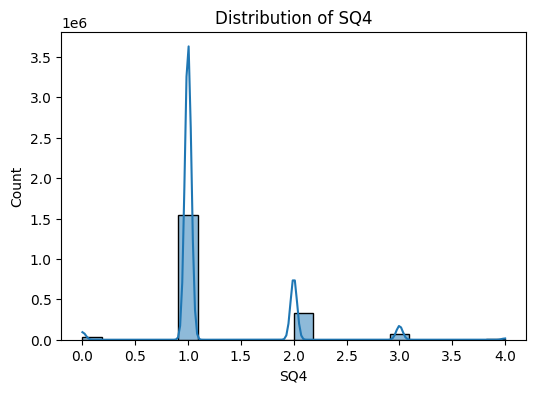

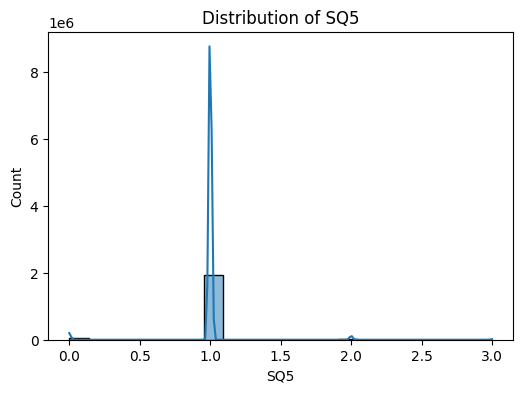

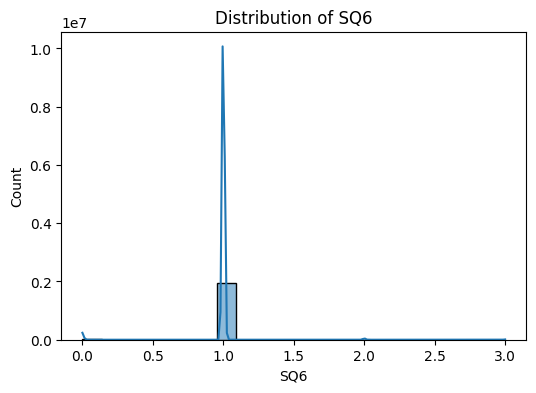

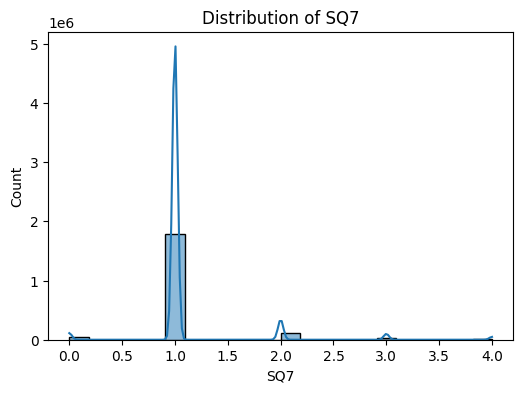

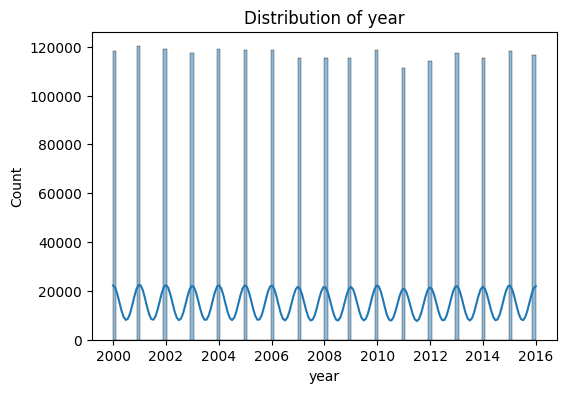

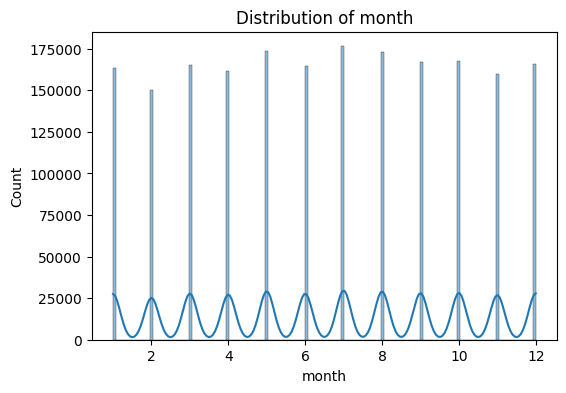

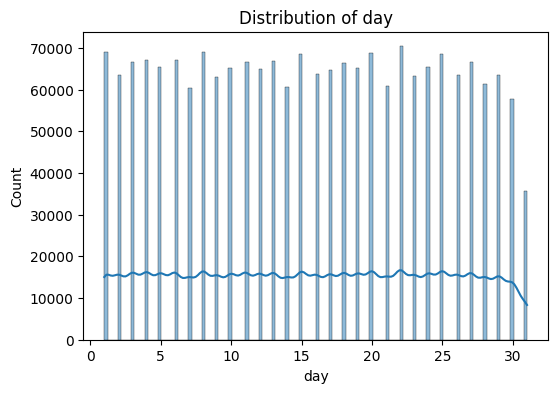

In [14]:
#univariate analysis
for col in data.columns:
    plt.figure(figsize=(6,4))
    sns.histplot(data[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()
        

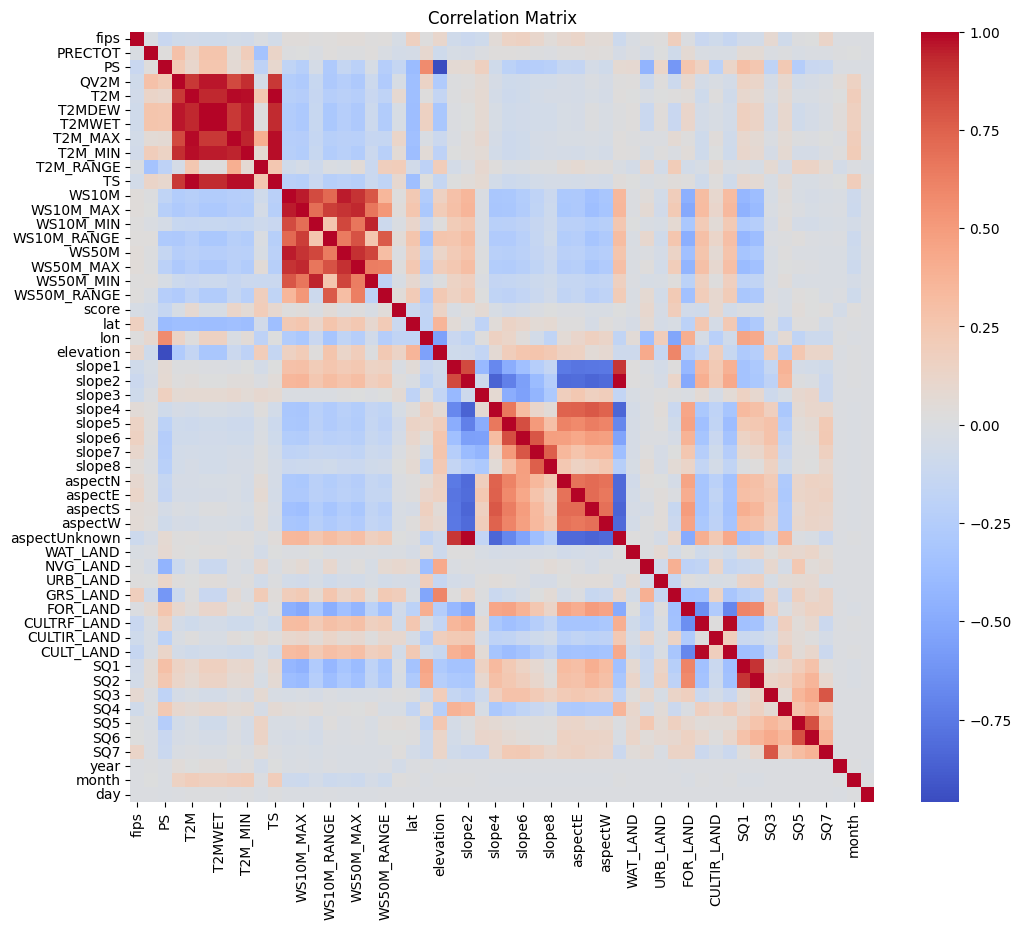

In [15]:
# plt.figure(figsize=(8,6))
# sns.boxplot(x=target, y='PRECTOT', data=data)
# plt.title('Precipitation vs Drought Severity')
# plt.show()

plt.figure(figsize=(12,10))
sns.heatmap(data[numeric_cols].corr(), cmap='coolwarm', annot=False)
plt.title('Correlation Matrix')
plt.show()

In [16]:
data.corr()

,fips,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,...,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7,year,month,day
fips,1.000000,-0.012855,-0.123252,-0.074118,-0.063964,-0.072736,-0.072929,-0.061967,-0.065522,-0.005352,...,-0.065766,-0.056263,0.083103,-0.077562,0.008684,0.018912,0.132474,-0.002257,0.001436,0.000292
PRECTOT,-0.012855,1.000000,0.035914,0.285575,0.132651,0.263253,0.263231,0.062637,0.189758,-0.336454,...,0.064302,0.061091,-0.008660,0.011765,-0.020741,-0.007480,-0.007465,0.011671,0.018308,0.001876
PS,-0.123252,0.035914,1.000000,0.223483,0.110627,0.257034,0.256925,0.070299,0.145294,-0.190315,...,0.289279,0.245645,-0.180921,0.231923,-0.241761,-0.119452,-0.113712,-0.004645,-0.003579,-0.007534
QV2M,-0.074118,0.285575,0.223483,1.000000,0.891938,0.962250,0.963202,0.832977,0.923408,-0.046042,...,0.147241,0.125721,-0.043580,0.098641,-0.062707,-0.038270,-0.010219,0.049386,0.152639,-0.000337
T2M,-0.063964,0.132651,0.110627,0.891938,1.000000,0.935288,0.935768,0.984863,0.983260,0.245904,...,0.102609,0.079995,-0.020494,0.069601,-0.021025,-0.021091,0.005118,0.014583,0.195720,0.007993
T2MDEW,-0.072736,0.263253,0.257034,0.962250,0.935288,1.000000,0.999977,0.885972,0.954688,0.027046,...,0.167661,0.142213,-0.050039,0.097500,-0.074356,-0.044056,-0.015281,0.038184,0.172294,0.006636
T2MWET,-0.072929,0.263231,0.256925,0.963202,0.935768,0.999977,1.000000,0.886410,0.955213,0.026916,...,0.167504,0.142033,-0.050019,0.097599,-0.074148,-0.044031,-0.015264,0.038320,0.172261,0.006578
T2M_MAX,-0.061967,0.062637,0.070299,0.832977,0.984863,0.885972,0.886410,1.000000,0.943637,0.401166,...,0.097955,0.072608,-0.005951,0.059286,0.007317,0.004773,0.016451,0.004356,0.192343,0.004310
T2M_MIN,-0.065522,0.189758,0.145294,0.923408,0.983260,0.954688,0.955213,0.943637,1.000000,0.075374,...,0.108936,0.088520,-0.033365,0.077397,-0.046301,-0.045033,-0.004519,0.023643,0.209892,0.010118
T2M_RANGE,-0.005352,-0.336454,-0.190315,-0.046042,0.245904,0.027046,0.026916,0.401166,0.075374,1.000000,...,-0.006373,-0.026234,0.074411,-0.035586,0.150186,0.139010,0.062070,-0.052305,-0.001407,-0.015017


In [17]:
data.corr()['score']


fips            -0.026287
PRECTOT         -0.051483
PS              -0.141614
QV2M            -0.029987
T2M              0.088651
T2MDEW          -0.030752
T2MWET          -0.030129
T2M_MAX          0.122683
T2M_MIN          0.061650
T2M_RANGE        0.198994
TS               0.096429
WS10M            0.023082
WS10M_MAX        0.037758
WS10M_MIN       -0.008404
WS10M_RANGE      0.056438
WS50M            0.003932
WS50M_MAX        0.021401
WS50M_MIN       -0.023382
WS50M_RANGE      0.050955
score            1.000000
lat             -0.115842
lon             -0.168805
elevation        0.142311
slope1          -0.012423
slope2           0.025842
slope3           0.066851
slope4          -0.026286
slope5          -0.067943
slope6          -0.048187
slope7          -0.009821
slope8           0.014839
aspectN         -0.001617
aspectE          0.003101
aspectS         -0.017686
aspectW         -0.024559
aspectUnknown    0.018100
WAT_LAND        -0.006818
NVG_LAND         0.101605
URB_LAND    

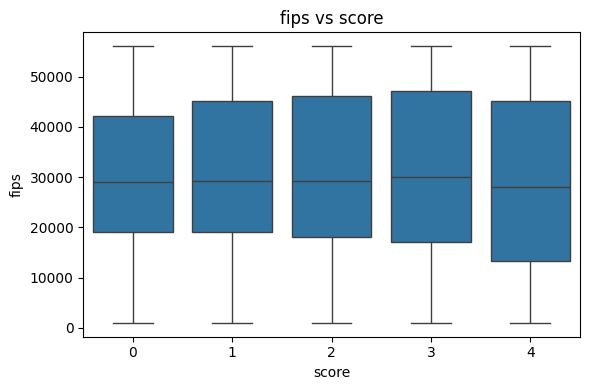

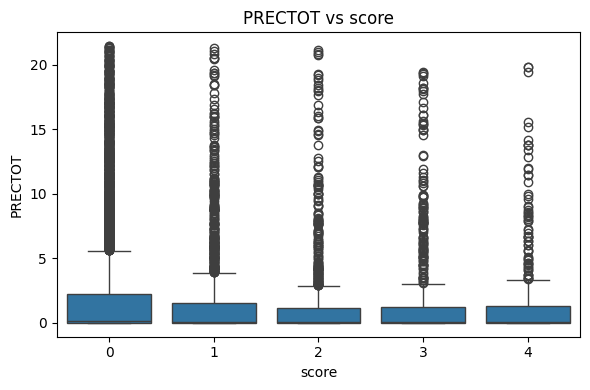

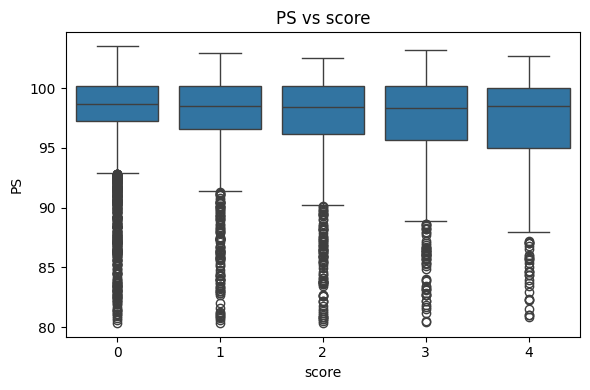

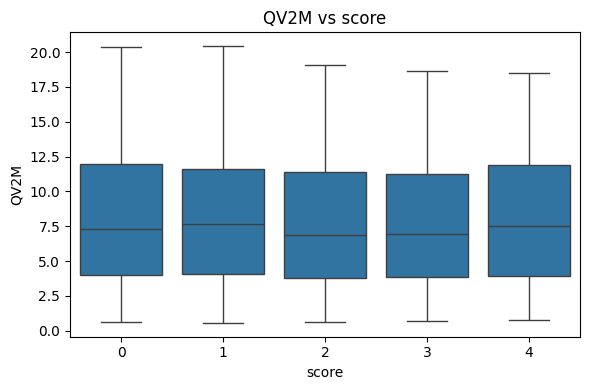

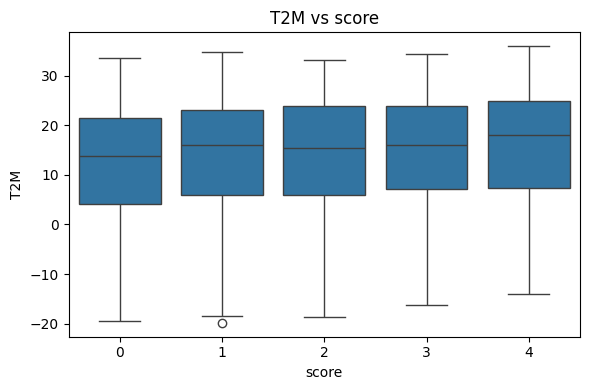

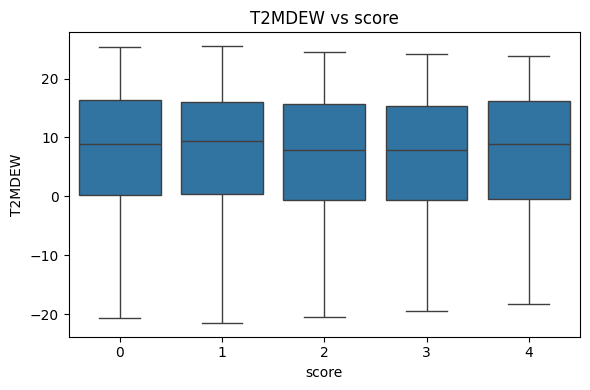

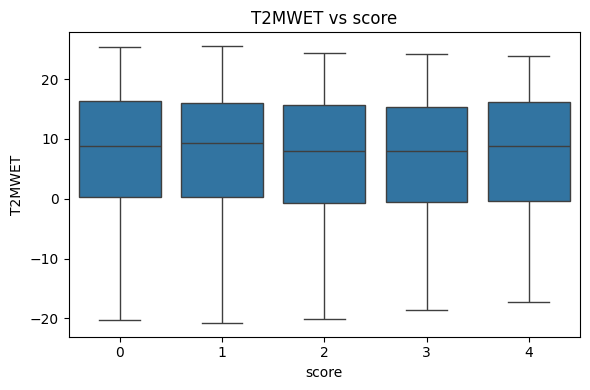

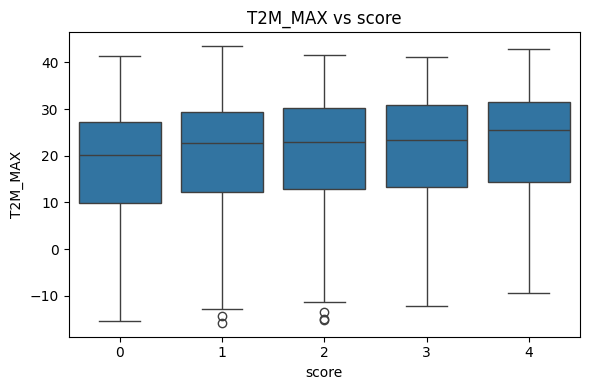

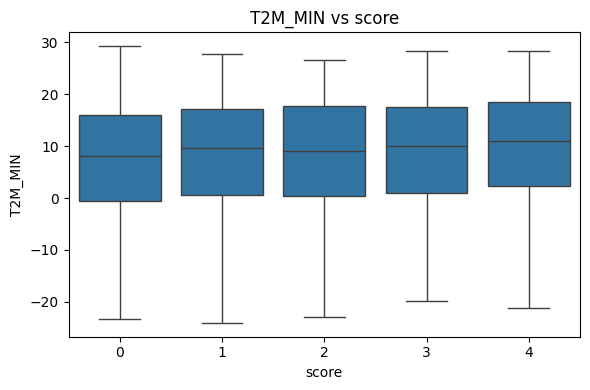

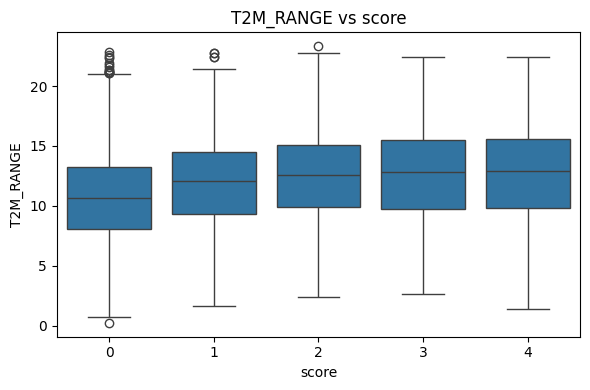

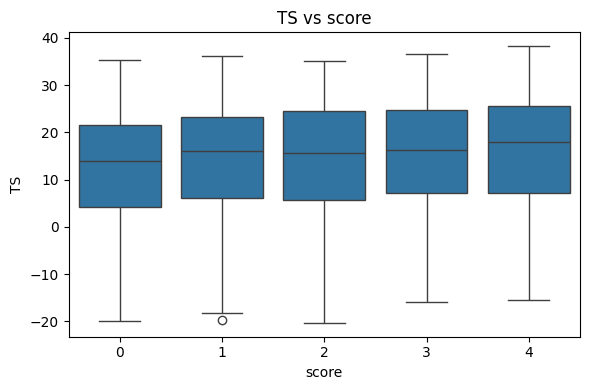

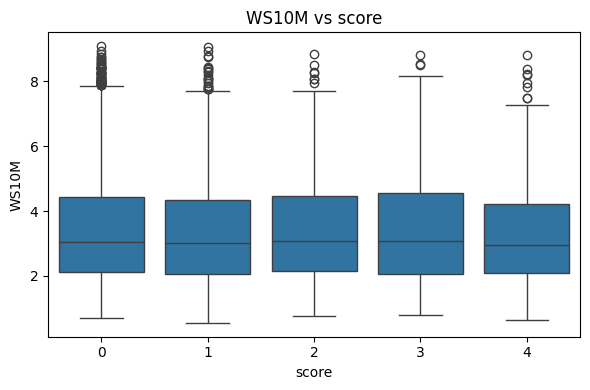

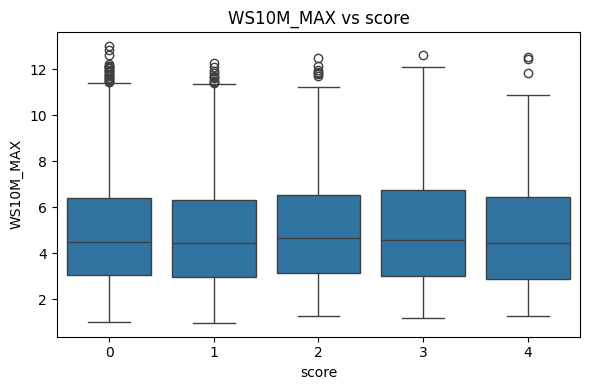

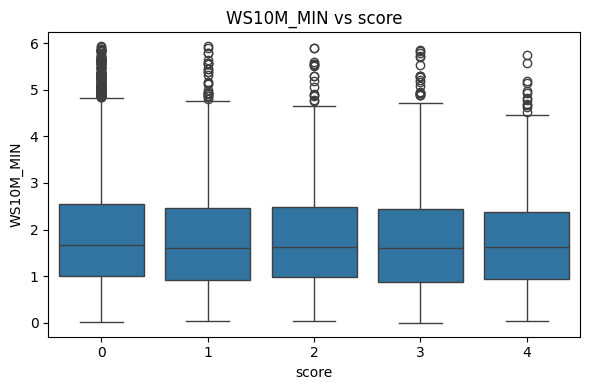

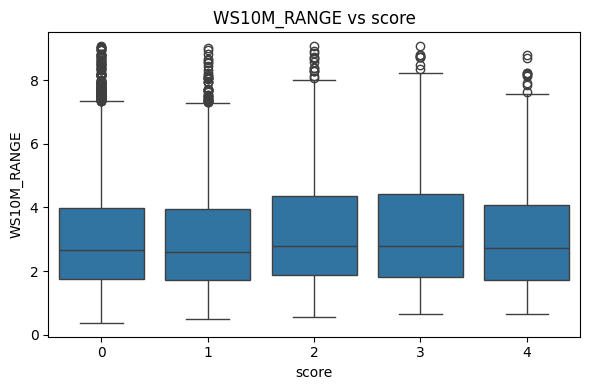

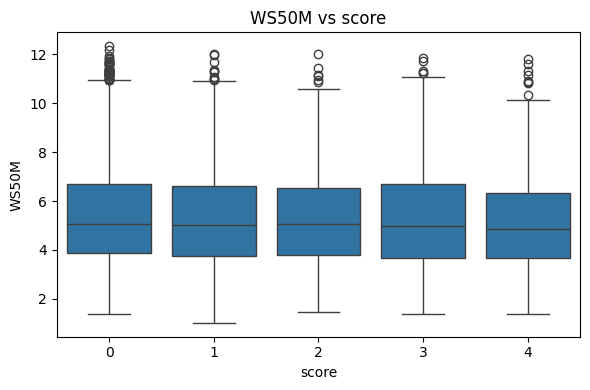

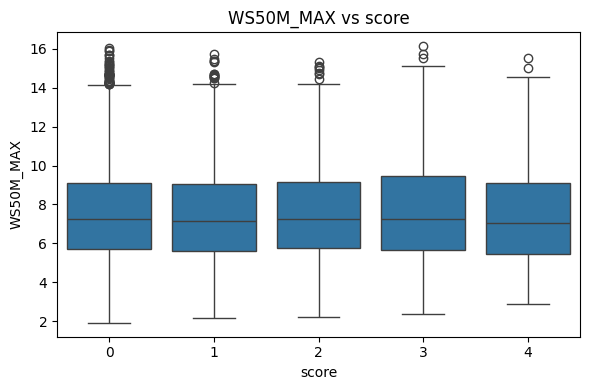

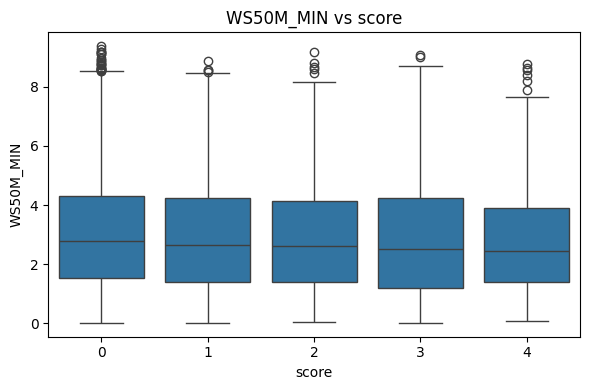

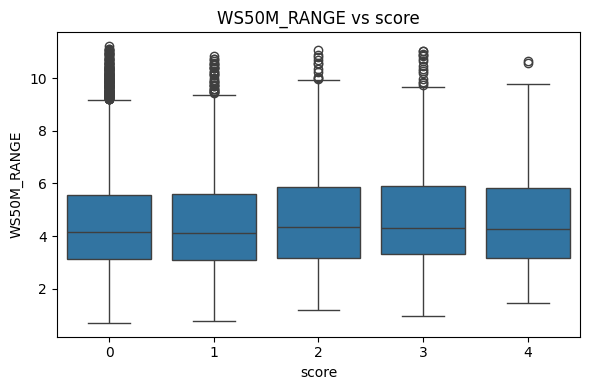

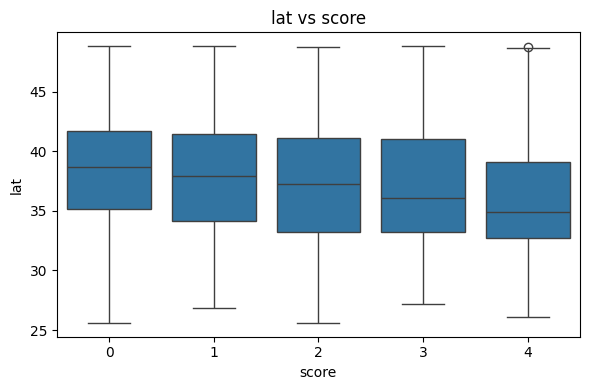

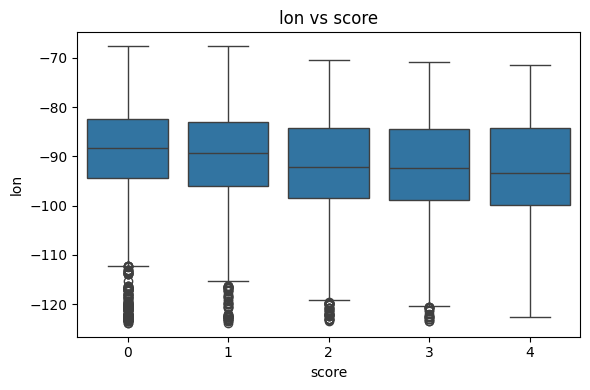

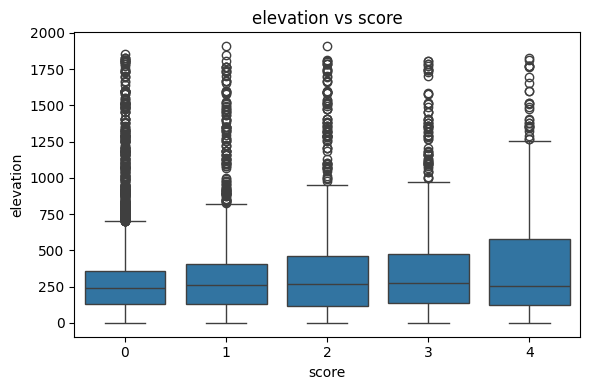

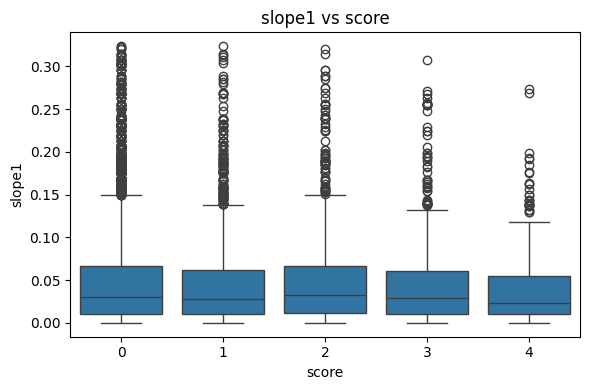

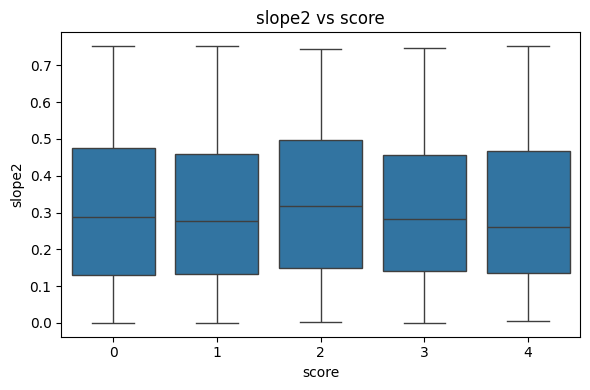

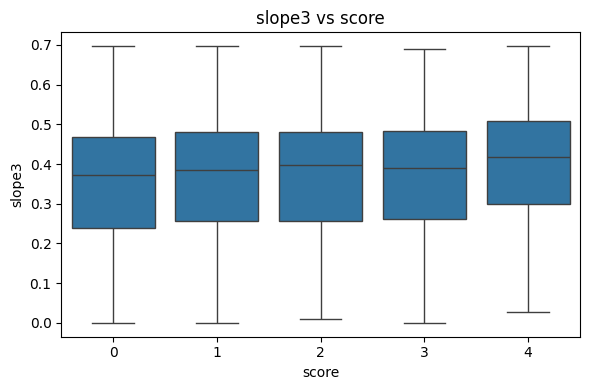

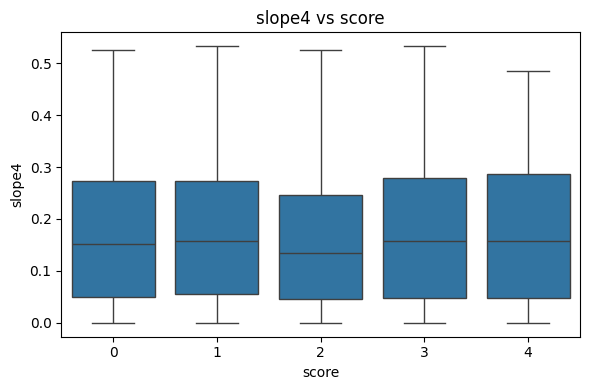

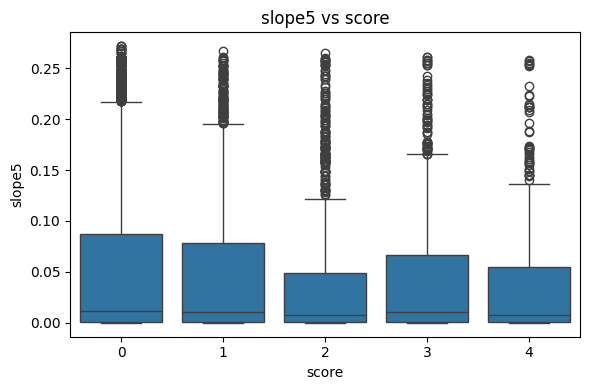

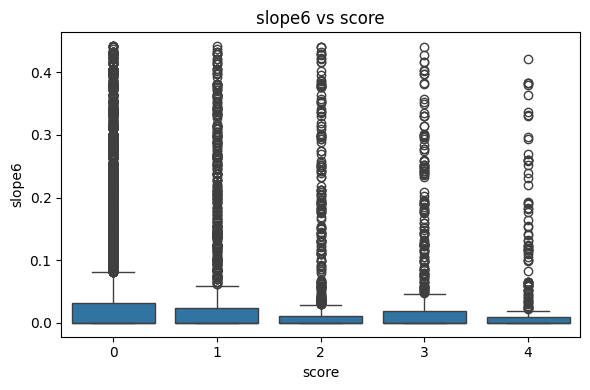

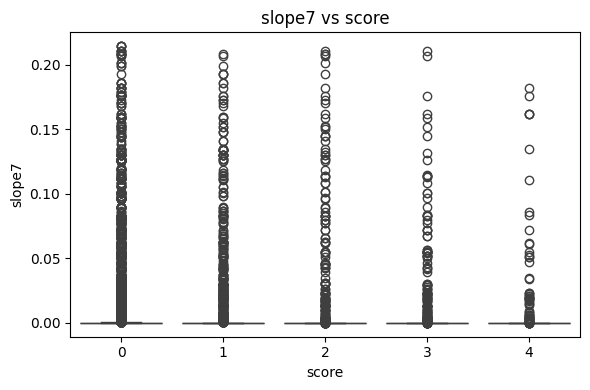

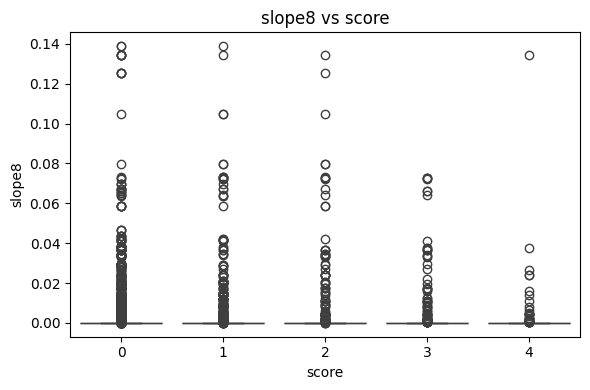

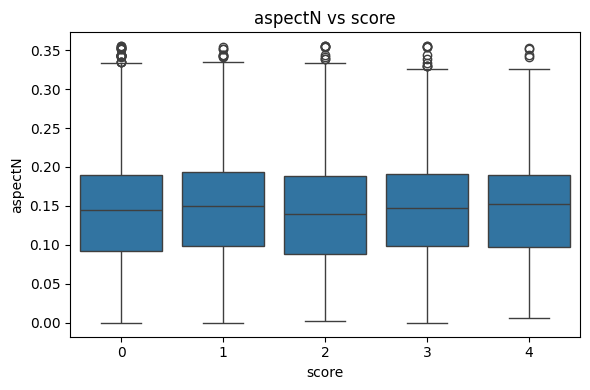

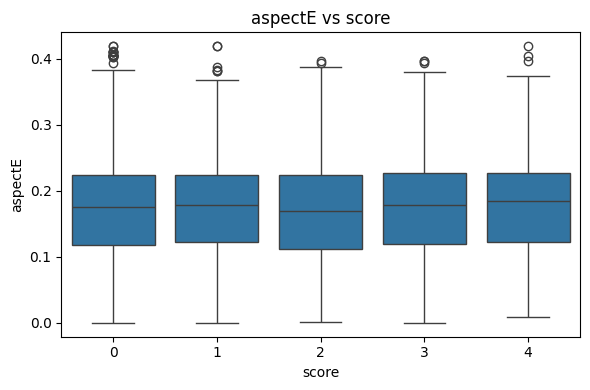

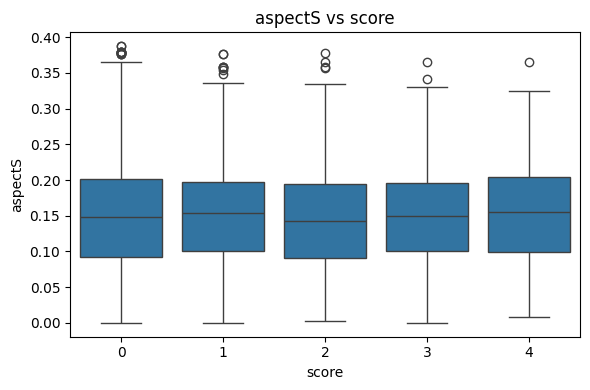

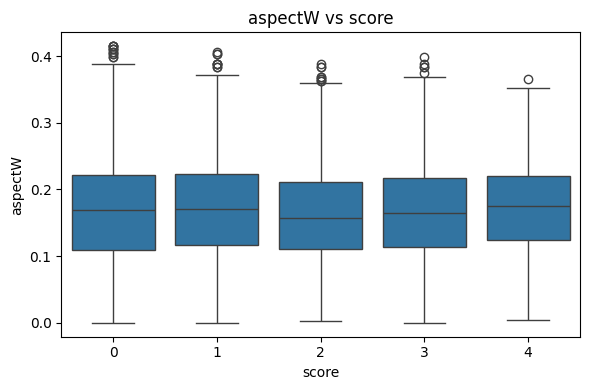

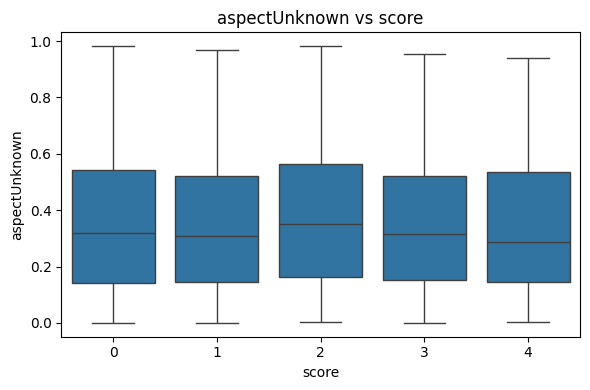

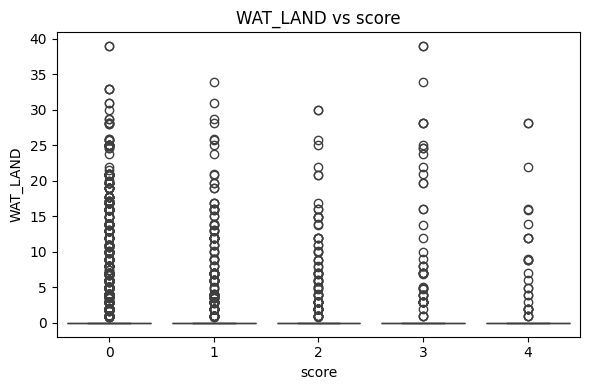

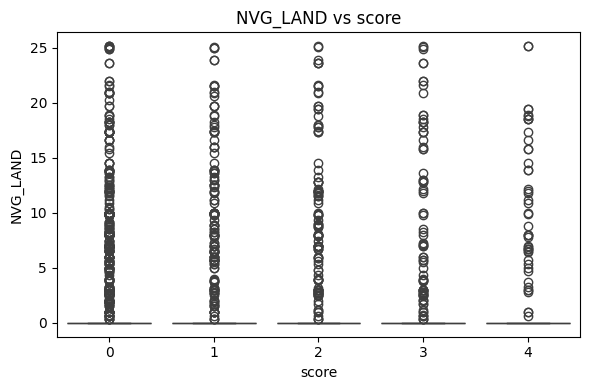

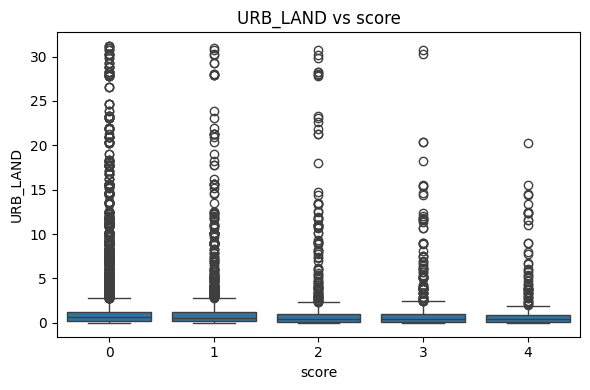

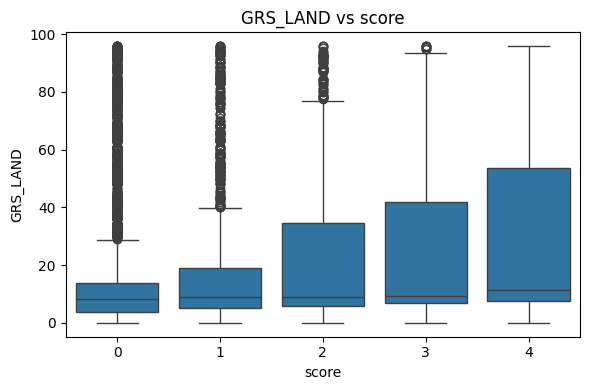

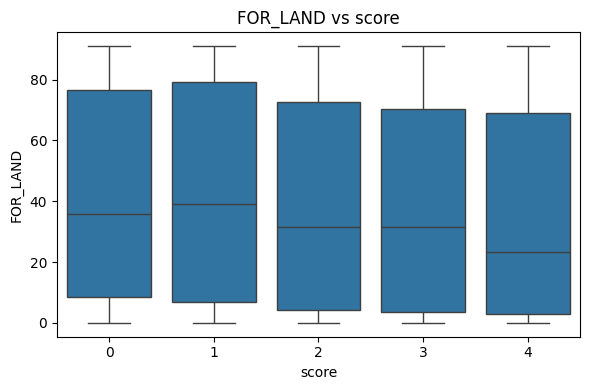

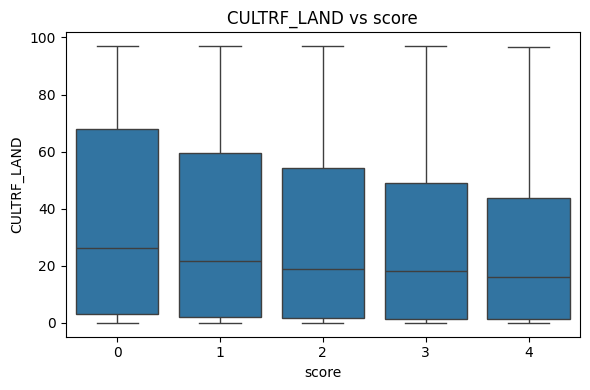

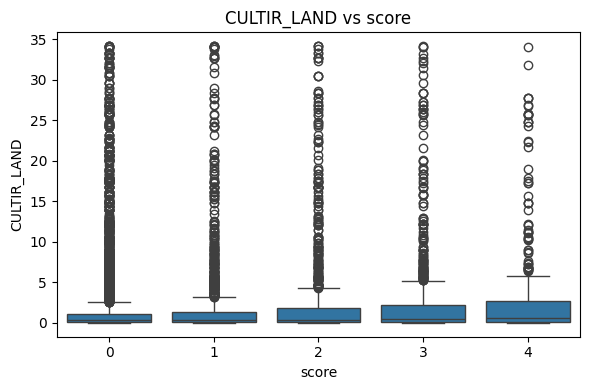

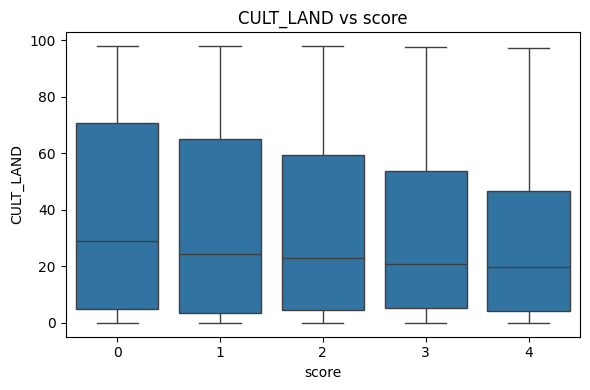

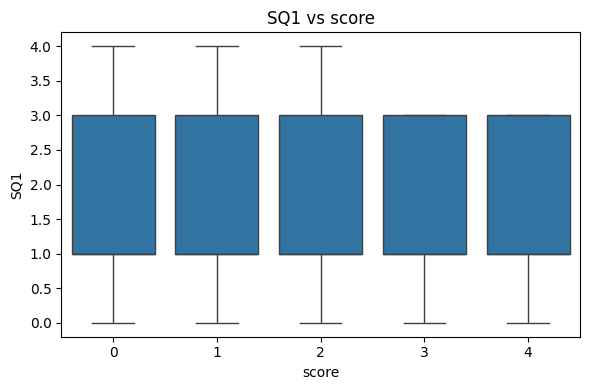

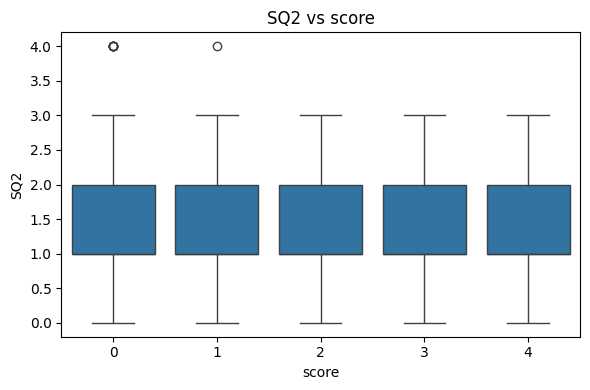

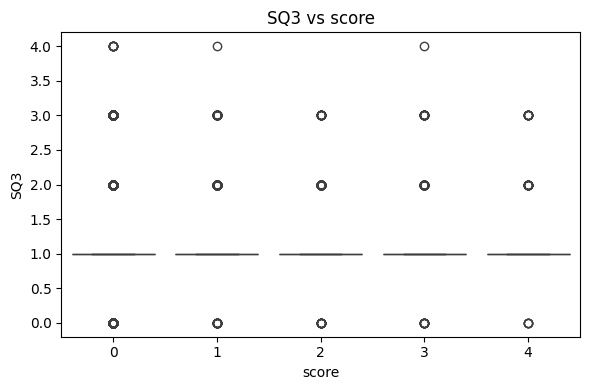

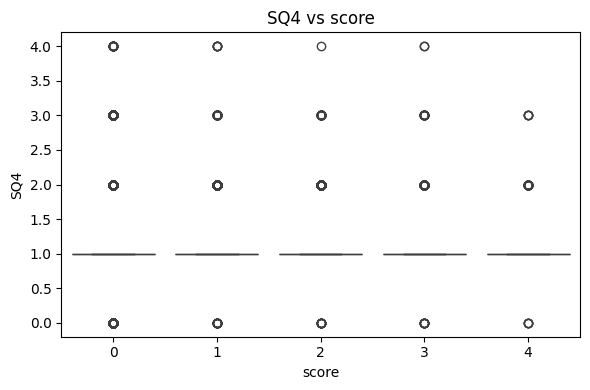

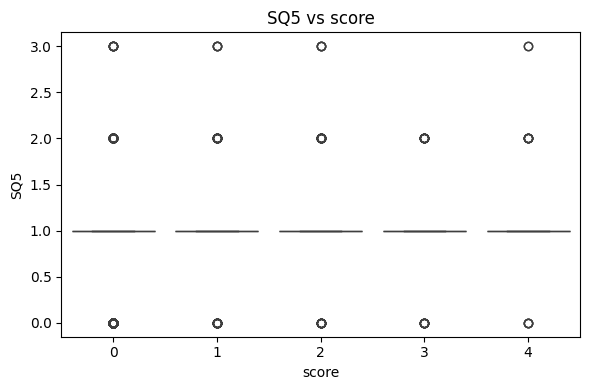

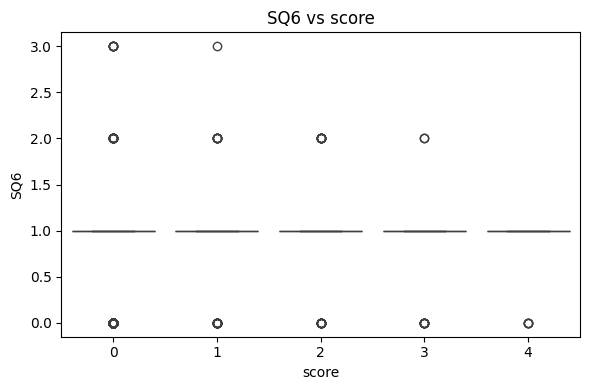

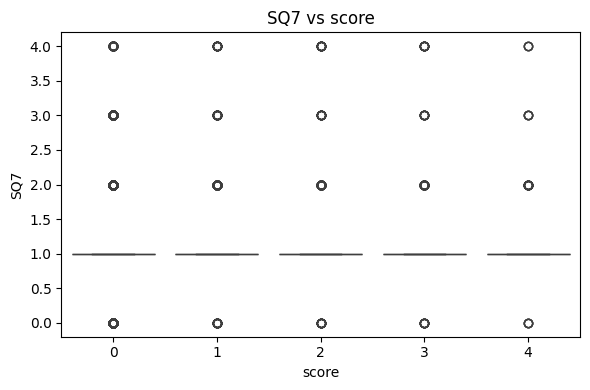

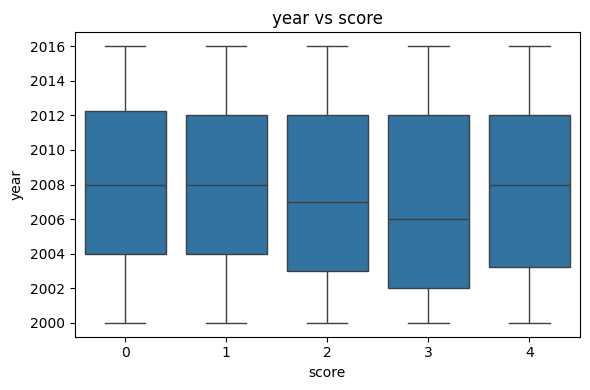

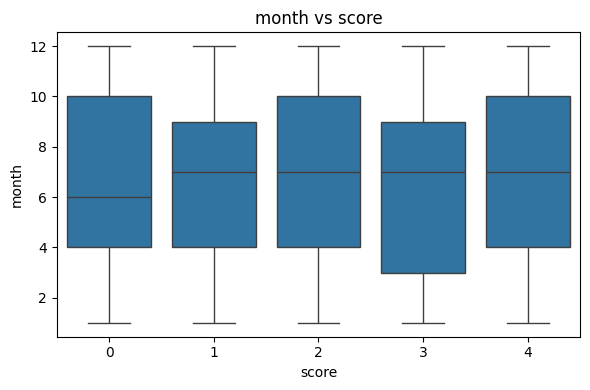

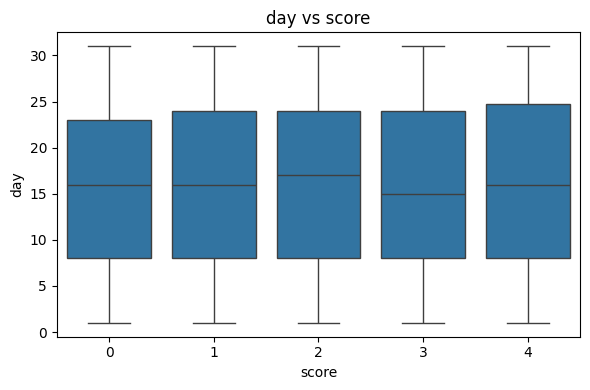

In [25]:
# Sample and make sure 'score' is categorical
sample_data = data.sample(n=10000, random_state=42)
sample_data['score'] = sample_data['score'].round().astype(int)
num_cols = data.select_dtypes(include='number').columns
num_cols = [col for col in num_cols if col != 'score'] 
# Define important columns (no spaces!)
imp_cols = ['T2M_MAX', 'T2M_RANGE', 'lat', 'GRS_LAND']

# Boxplots of important variables vs score
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='score', y=col, data=sample_data)
    plt.title(f"{col} vs score")
    plt.tight_layout()
    plt.show()

In [29]:
# Sample and prepare
sample_data = data.sample(n=10000, random_state=42)
sample_data['score'] = sample_data['score'].round().astype(int)

# Define important columns
imp_cols = ['T2M_MAX', 'T2M_RANGE', 'lat', 'GRS_LAND']

for col in imp_cols:
    fig = px.violin(sample_data, x='score', y=col, box=True, points='all', color='score',
                    title=f'{col} vs Score', width=800, height=500)
    fig.show()